# FVMBV - Advanced Method of Medical Image Processing
## Exercise 1: Image Denoising with Laplacian matrix and total variation (TV) regularization
In this first exercise you will learn to implement a smoothing operation on image grids by solving a linear system of equations and by using total variation with gradient descent.

For the Bonus tasks, you will implement Gauss-Seidel optimization in C++ as an inline extension and then use it to solve the linear system of equations. The second bonus task is to implement a bilateral filter in Python.

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import trange
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import time
# load image
!wget -nc https://cloud.imi.uni-luebeck.de/s/fBnwQNLWXNDqsj5/download -O ct_image_pytorch.pth
!wget -nc https://cloud.imi.uni-luebeck.de/s/mwkHe3ryAxq5pqZ/download -O utils.py
img = torch.load('ct_image_pytorch.pth').squeeze()
H, W = img.shape
H1,W1 = img.shape


File ‘ct_image_pytorch.pth’ already there; not retrieving.
File ‘utils.py’ already there; not retrieving.


Our image is quite clean, so we will add some noise to it to the denoising task more challenging.

So let's add some gaussian noise to the image:
$$
\mathbf{y} = \mathbf{x} + \mathcal{N}(0,\sigma^2)
$$
where $\sigma^2$ is the variance of the gaussian noise.

and visualize the noisy image:

In [37]:
# given function to add noise to image
def add_gaussian_noise(img, noise_level):
    return img + torch.randn_like(img) * noise_level


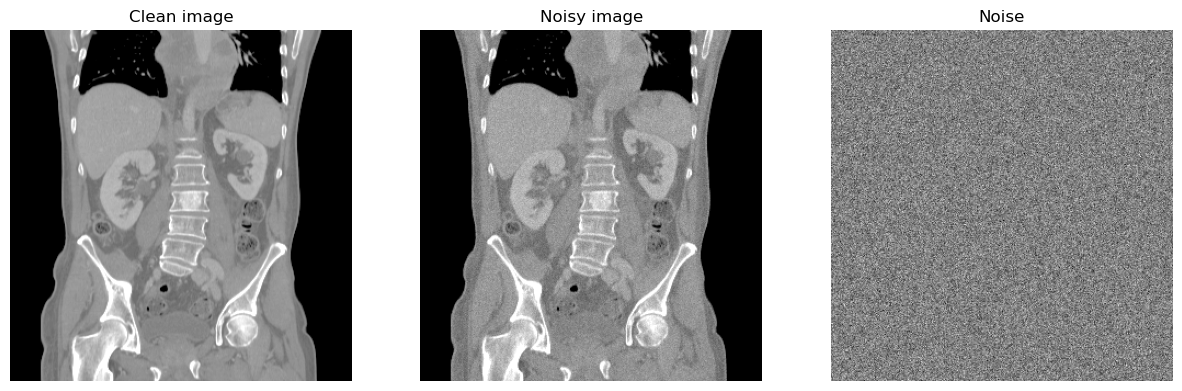

In [38]:
# add noise
sigma = 30

# generate noisy image
noise_img = add_gaussian_noise(img, sigma)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(torch.clamp(img, -500, 500), 'gray')
ax[0].set_title('Clean image')
ax[0].axis('off')

ax[1].imshow(torch.clamp(noise_img, -500, 500), 'gray')
ax[1].set_title('Noisy image')
ax[1].axis('off')

ax[2].imshow(torch.clamp(noise_img - img, -500, 500), 'gray')
ax[2].set_title('Noise')
ax[2].axis('off')
plt.show()


# Task 1: Laplacian matrix for edge preserving filtering
First we need to define an operator that defines spatial neighbours in horizontal and vertical direction. 

In exercise 0 this was realised using a sparse matrix, for efficiency we use here use a convolution operator to extract four neighbours each. Note that for a 2D image of size $H \times W$ we can access a vectorised view using 1D integer indices ranging from 0 to $HW$.

### Define the neighbourhood operator

We want to use four neighbours for each pixel to apply our edge preserving filtering and hence need an operator that extracts those from a 2D image. ``F.conv2d`` together with a padding operator, e.g. ``nn.ReplicationPad2d(1)`` is ideally suited for this purpose, but we manually need to define its filter kernel.

Create a tensor called ``neighbours`` of all zeros of shape 4 x 3 x 3. Next set the left element of the first filter, the top element of the second, the bottom element of the third and the right element of the fourth to one, so that:

$$
\text{neighbours[0]:}
\begin{bmatrix}
0 & 0 & 0\\
1 & 0 & 0\\
0 & 0 & 0\\
\end{bmatrix},  

\text{neighbours[1]:}
\begin{bmatrix}
0 & 1 & 0\\
0 & 0 & 0\\
0 & 0 & 0
\end{bmatrix},  

\text{neighbours[2]:}
\begin{bmatrix}
0 & 0 & 0\\
0 & 0 & 0\\
0 & 1 & 0\\
\end{bmatrix},  

\text{neighbours[3]:}
\begin{bmatrix}
0 & 0 & 0\\
0 & 0 & 1\\
0 & 0 & 0\\
\end{bmatrix} 
$$

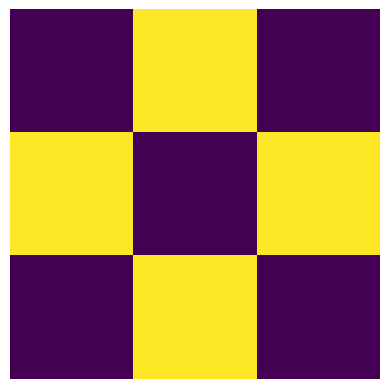

In [18]:
neighbours = torch.zeros(4,3,3)
neighbours[0,1,0] = 1; neighbours[1,0,1] = 1; neighbours[2,2,1] = 1; neighbours[3,1,2] = 1

# print the neighbours as a checkboard with ones being black and zeros being white on a grid
# yellow are 4 neighbours of the center pixel
plt.imshow(neighbours.sum(0))
plt.axis('off')
plt.show()

#Todo: Reshape the tensor to 4x1x3x3 to simplify the use as a convolutional kernel
neighbours = neighbours.reshape(4,1,3,3)



With this auxiliary tensor at hand, we can easily extract the four neighbours for each pixel and compute the weights for our denoising task. That means, we need to create edge-preserving weights as defined in the lecture using intensity differences. 

For this purpose we define the coordinates $x_i$ as the regular (original) grid of the input image and $x_j$ as its spatial neighbours and put the extracted values in the following equation:
$w_{ij} = \lambda ⋅ \exp \left( -\sigma^2 ⋅ ( \text{img}[{x}_{i}] - \text{img}[{x}_{j}] )^2 \right)$ where the hyperparameters are chosen as $\lambda=-200$ and $\sigma^2=0.0016$.

To extract $x_j$ we can simply call ``F.conv2d(nn.ReplicationPad2d(1)(img.unsqueeze(0).unsqueeze(0),neighbours)``.

Take care to adjust the views of the tensors correctly to obtain a ``weight``of shape 4 x 99840. For later use as a (sparse) linear system, these off-diagonal elements have to be negated.

You shall also directly obtain the diagnoal elements by summing over the first dimension of the weights tensor and negating the result. Remember to add one to every element as explained in the lecture for the task of denoising.


In [33]:
# Given: extract the neighbours of the image using the convolution operation
x_j = F.conv2d(nn.ReplicationPad2d(1)(noise_img.view(1,1,H1,W1)),neighbours)
# Todo: compute the weights for the neighbours and reshape the tensor to have 4 rows for all pixels
weights = - 200 * torch.exp(-0.0016 * (noise_img.unsqueeze(0)-x_j.squeeze(0))**2).reshape(4,-1)
# Todo: compute the diagonal of the weight  matrix
diag = -weights.sum(0)+1
print('weights shape:', weights.shape, '\ndiag shape',diag.shape)


weights shape: torch.Size([4, 99840]) 
diag shape torch.Size([99840])


### Optimizer: Gauss-Seidel with red-black ordering

To implement the red-black Gauss-Seidel solver, we need another auxiliary function to extract the checkboard-pattern from any given 2D tensor. If you want to see a good visual explanation of the red-black scheme for grids have a look at Jeffrey Chasnos' video https://www.youtube.com/watch?v=giTZ89q-Bpk 

We start by finding all pixel indices for red and black respectevely. Since the product of the image height and width is not even, we cannot simply use every second index. You can think of it as finding all coloured squares of a chessboard. 

First, create meshgrids for height and width with `torch.meshgrid` ([Documentation](https://pytorch.org/docs/stable/generated/torch.meshgrid.html)). To create the checkerboard, perform a modulo operation on the sum of both meshgrids. Now can simply extract `red` and `black` with `torch.where` ([Documentation](https://pytorch.org/docs/stable/generated/torch.where.html)).

In [35]:
# Todo: create meshgrids for the x and y coordinates of the image
mesh_x, mesh_y = torch.meshgrid(torch.arange(H1), torch.arange(W1))
checkerboard = ((mesh_x + mesh_y) % 2)

#Todo: flatten the checkerboard and extract all values for red (checkerboard == 1) and black (checkerboard == 0) 
checkerboard = checkerboard.view(-1)
red = torch.where(checkerboard == 1)[0]
black = torch.where(checkerboard == 0)[0]


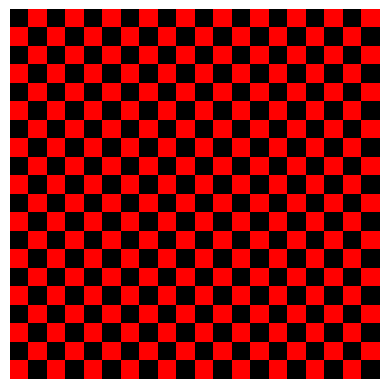

In [36]:
#check the created checkerboard by plotting the matrix
plot_checkerboard = torch.zeros(H1*W1,3)
plot_checkerboard[red,0] = 1
plt.imshow(plot_checkerboard.view(H1,W1,3)[:20,:20])
plt.axis('off')
plt.show()


We are now ready to implement the Gauss-Seidel solver. Looking at https://en.wikipedia.org/wiki/Gauss–Seidel_method the iterative update formula, which is based on forward substitution is

$$
x^{(k+1)}_i  = \frac{1}{a_{ii}} \left(b_i - \sum_{j=1}^{i-1}a_{ij}x^{(k+1)}_j - \sum_{j=i+1}^{n}a_{ij}x^{(k)}_j \right),\quad i=1,2,\dots,n.
$$

Which can be further simplified to

$$
x^{(k+1)}_i  = \frac{1}{a_{ii}} \left(b_i - \sum _{j\neq i}a_{ij}x_{j} \right).
$$

Here $a_{ii}$ are elements on the main diagonal that we stored in ``diag`` whereas $a_{ij}$ are the neighbours in ``weights`` (each pixel has exactly four neighbours in our case). $b_i$ denotes the noisy image. The condition $j\neq i$ is always fulfilled because ``weights`` itself contains no elements on the main diagonal.

Initialise the solution vector to ``x = img.reshape(-1).clone()`` and implement this algorithm within a for-loop (50 iterations) using the following four steps:

1) extract neighbours from current version of x using the unfold-convolution as above.

2) update only the red parts of x using the equation above the summation simply leads to ``(weight[:,red]*x_unfold[:,red]).sum(0)``

3) repeat step 1)

4) repeat step 2) but this time update the black parts

In [37]:
# Gauss-Seidel iterations
def gauss_seidel(img,weight,neighbours,red,black, num_iter=50):
    
    # Given: Initialize x with the noisy image
    x = img.reshape(-1).clone()
    # Given: For storing the intermediate results
    x_all = torch.zeros(num_iter,x.numel())
    
    with torch.no_grad():
        for i in trange(num_iter):
            # Todo: exract the neighbours of the previous iteration 
            x_unfold = F.conv2d(nn.ReplicationPad2d(1)(x.view(1,1,H1,W1)),neighbours).view(4,-1)
            # Todo: Update red squares using the neighbours from the previous iteration
            x[red] = 1/diag[red]*(img.reshape(-1)[red]-(weight[:,red]*x_unfold[:,red]).sum(0))
            # Todo: exract the neighbours of the current iteration 
            x_unfold = F.conv2d(nn.ReplicationPad2d(1)(x.view(1,1,H1,W1)),neighbours).view(4,-1)
            # Todo: Update black with infromation of the red neighbourhood from current iteration
            x[black] = 1/diag[black]*(img.reshape(-1)[black]-(weight[:,black]*x_unfold[:,black]).sum(0))
            # Given: Store the current iteration
            x_all[i] = (x.clone())
    return x,x_all

t0 = time.time()
x_gs,x_gs_all = gauss_seidel(noise_img,weights,neighbours,red,black)
t1 = time.time()
time_gs = t1-t0
print(f'Gauss-Seidel took {time_gs:.2f} seconds')


  0%|          | 0/50 [00:00<?, ?it/s]

Gauss-Seidel took 0.21 seconds


Visualize your results

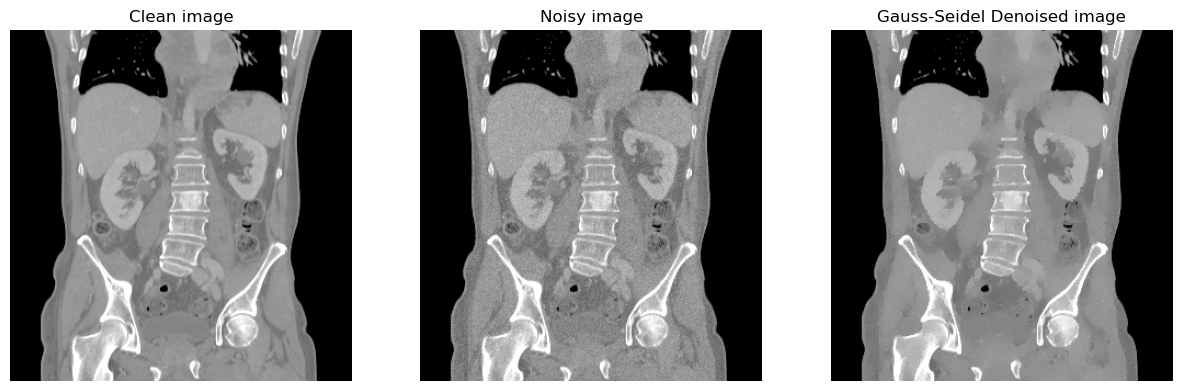

In [38]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(torch.clamp(img, -500, 500), 'gray')
ax[0].set_title('Clean image')
ax[0].axis('off')
ax[1].imshow(torch.clamp(noise_img, -500, 500), 'gray')
ax[1].set_title('Noisy image')
ax[1].axis('off')
ax[2].imshow(torch.clamp(x_gs.view(H1,W1), -500, 500), 'gray')
ax[2].set_title('Gauss-Seidel Denoised image')
ax[2].axis('off')
plt.show()


### Comparison optimizers (given code)
In this section, we will compare our implemented solver against some baselines. Do not worry, everything is already implemented for you. Just run the cells below and enjoy the results.
The simpler Jacobi method does not use forward substitution and needs no red-black scheme.

In [10]:
from utils import jacobi_method

t0 = time.time()
x_jac, x_jac_all = jacobi_method(noise_img, weights, neighbours, diag)
t1 = time.time()
time_jac = t1 - t0

print(f'Jacobi took {time_jac:.2f} seconds')


100%|██████████| 50/50 [00:00<00:00, 625.60it/s]

Jacobi took 0.08 seconds


Furthermore, we want to compare our implementation to a well-known conjugate gradient solver for arbitrary sparse linear systems. For that, we will create the sparse laplacian matrix.

In [11]:
from utils import sparseCG, laplacian

L, _ = laplacian(noise_img, weights, neighbours, diag)
t0 = time.time()
with torch.no_grad():
    x_cg,cg_residuals = sparseCG(L,noise_img.reshape(-1, 1), iterations=50)
t1 = time.time()
time_cg = t1-t0

print(f'Conjugate Gradient took {time_cg:.2f} seconds')


minimizing energy equation: 100%|██████████| 50/50 [00:00<00:00, 98.05it/s]

Conjugate Gradient took 0.52 seconds


Finally, we need to calculate the residual errors for every step of our Gauss-Seidel implementation and the Jacobi method to compare their performance.

In [12]:
gs_residual = torch.zeros(len(x_gs_all))
jac_residual = torch.zeros(len(x_gs_all))
for i in range(len(x_gs_all)):
    residual1 = noise_img.reshape(-1, 1) - torch.spmm(L, x_gs_all[i].reshape(-1, 1))
    gs_residual[i] = residual1.norm()
    residual1 = noise_img.reshape(-1, 1) - torch.spmm(L, x_jac_all[i].reshape(-1, 1))
    jac_residual[i] = residual1.norm()
    
print(f'Gauss-Seidel residual: {gs_residual[-1]}')
print(f'Jacobi residual: {jac_residual[-1]}')


Gauss-Seidel residual: 7766.8447265625
Jacobi residual: 141070.140625


Plot the residual of all optimizers for comparison as well as the resulting images.

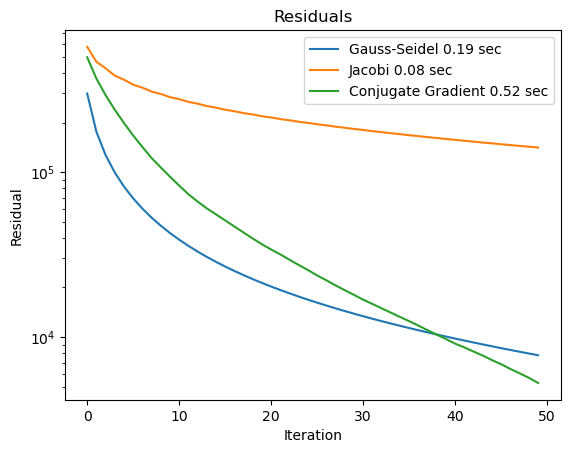

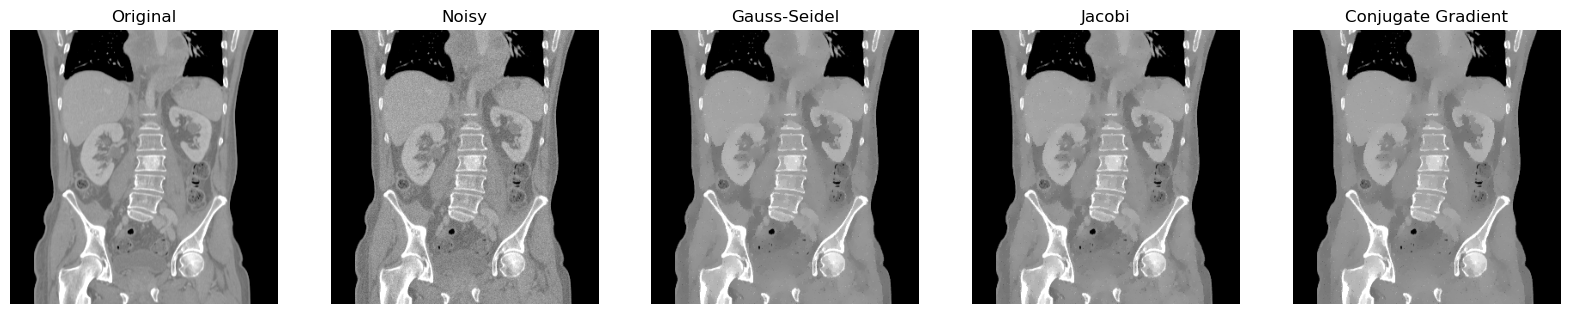

In [14]:
from utils import plot_comparison, show_comparison
plot_comparison(gs_residual,jac_residual,cg_residuals, [time_gs,time_jac,time_cg])
show_comparison(img.view(H1,W1),noise_img.view(H1,W1),x_gs.view(H1,W1),x_jac.view(H1,W1),x_cg.view(H1,W1))


As you can see Gauss-Seidel and Conjugate Gradient yield a visually similar denoising result. While each Gauss-Seidel iteration runs 7-8 times quicker and the residual converges faster in the beginning, conjugate gradient obtains a slightly better final solution. The Jacobi method is not very competitive.

## Task2: Denoising with Total Variation (TV) and Adam
In this task we will use the same image as in the previous task and try to denoise it using the total variation (TV) and optimisation with Adam. 

The aim here is to find a denoised image $\mathbf{x}$ that minimises the following energy function:
$$
E(\mathbf{x}) = E_{fidelity}(x,y) + \lambda E_{\text{TV}}(\mathbf{x})
$$
where $\mathbf{y}$ is the noisy input image and $\lambda$ is a hyperparameter that controls the amount of TV regularisation.



Now let's define the TV regularizer as follows:
$$
TV = \sum_{i,j} |\mathbf{x}_{i+1,j} - \mathbf{x}_{i,j}| + |\mathbf{x}_{i,j+1} - \mathbf{x}_{i,j}|

$$
where $\mathbf{x}_{i,j}$ is the pixel value at position $(i,j)$ in the image $\mathbf{x}$, which can be accessed by indexing the image.

Useful operations for this task are:
- `torch.abs` for computing the absolute value
- `torch.sum` for summing up the values of a tensor

In [39]:
# Todo: implement the finite differences
def finite_differences(img):
    dx = img[:, 1:] - img[:, :-1]
    dy = img[1:, :] - img[:-1, :]
    return dx, dy


# Todo: implement total variation regularization
def total_variation(x):
    # Todo: compute the finite difference of x and y as dx and dy 
    dx, dy = finite_differences(x)
    # Todo: compute the total variation
    tv_loss = torch.sum(torch.abs(dx)) + torch.sum(torch.abs(dy)) 
    return tv_loss


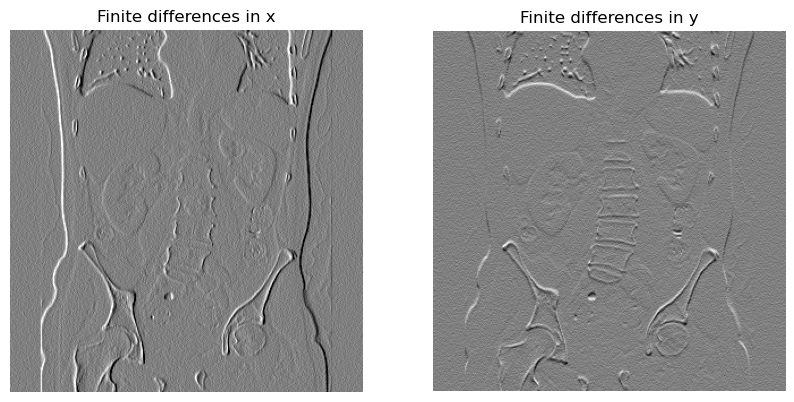

In [40]:
# plot finite differences for visualization
diff_x, diff_y = finite_differences(noise_img)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(torch.clamp(diff_x, -500, 500), 'gray')
ax[0].set_title('Finite differences in x')
ax[0].axis('off')

ax[1].imshow(torch.clamp(diff_y, -500, 500), 'gray')
ax[1].set_title('Finite differences in y')
ax[1].axis('off')
plt.show()


Next we need to define the data fidelity term. For this purpose we will use the mean squared error (MSE) between the denoised image $\mathbf{x}$ and the noisy image $\mathbf{y}$:
$$
E_{fidelity}(\text{x},\text{y}) = \frac{1}{i*j}\sum_{i,j} \left( \text{x}_{i,j} - \text{y}_{i,j} \right)^2
$$

Useful operations for this task are:
- `torch.pow` for computing the power of a tensor
- `torch.mean` for computing the mean of a tensor



In [41]:
def data_fidelity(x, y):
    # we could also use torch.nn.functional.mse_loss(x, y)
    return (x - y).pow(2).mean()


Now that we defined the losses, we can start with the optimisation. For this purpose we will use the Adam optimiser. The Adam optimiser is a gradient descent method that uses adaptive momentum. We will use it to update the image $\mathbf{x}$ iteratively. The update rule for Adam is as follows:
$$
\mathbf{x}_{t+1} = \mathbf{x}_t - \frac{\mu}{\sqrt{\mathbf{v}_t} + \epsilon} m_t
$$
where $\mathbf{v}_t$ is the exponentially decaying average of past squared gradients, $\mu$ is the learning rate, and $\epsilon$ is a small constant to avoid division by zero, and $m_t$ is the momentum term.

The momentum term $m_t$ and the squared gradient term $\mathbf{v}_t$ are updated as follows:
$$
v_t =  \beta_2 v_{t-1} + (1−\beta_2) (\nabla E(\mathbf{x}_t))^2
$$

$$
m_t =  \beta_1 m_{t-1} + (1−\beta_1) \nabla E(\mathbf{x}_t)
$$

We do not need to compute the gradients and update the image ourselves. Instead we can use the `torch.optim.Adam` class.

In [53]:
# Todo: initialize denoised_image with the noisy image and set requires_grad to True
x_tv = noise_img.clone().requires_grad_(True)

# Todo: implement the Adam optimizer with a learning rate of 1
optimizer = torch.optim.Adam([x_tv], lr=1)


Finally, we can start the denoising for a given number of epochs. In each epoch we will compute the total variation and data fidelity loss and add them together to obtain the total loss. 

Useful operations for this task are:    
- `.zero_grad()` for setting the gradients to zero
- `.backward()` for computing the gradients
- `.step()` for updating the parameters

Iteration 99    Loss 0.4533


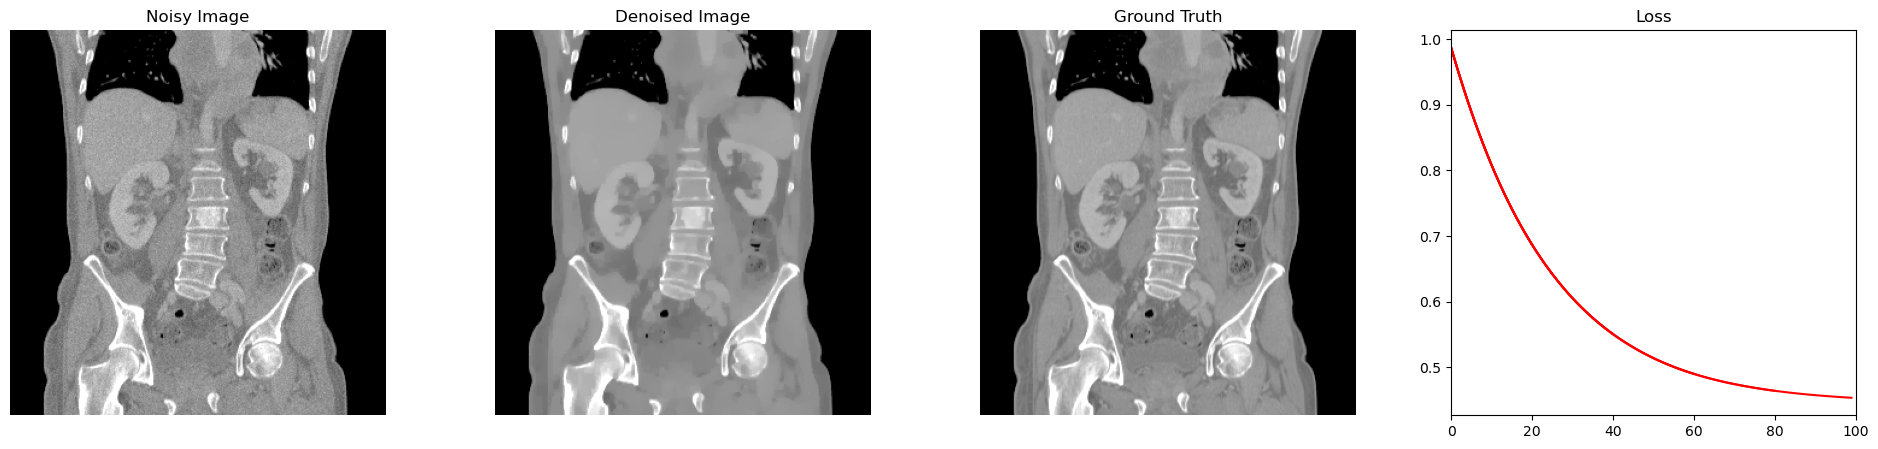

In [54]:
# number of iterations
num_iterations = 100

# try different values for lambda_tv -> what happens if you set it to 0? and what happens for large values?
lambda_tv = 0.001

# statistics
losses = []

# plotting
fig, ax = plt.subplots(1, 4, figsize=(24, 5))
labels = ['Noisy Image', 'Denoised Image', 'Ground Truth', 'Loss']
for i in range(4):
    ax[i].set_title(labels[i])
    if i != 3:
        ax[i].set_axis_off()
ax[3].set_xlim(0, num_iterations)


# denoise image with total variation regularization
for i in trange(num_iterations, desc='TV + Adam Denoising'):
    # Todo: reset the gradient
    optimizer.zero_grad()
    
    # Todo: implement the denoising loss function (2 pts)
    # data fidelity term between the denoised image and the noisy image
    loss_fidelity = data_fidelity(x_tv, noise_img)
    # total variation term of the denoised image
    loss_tv = total_variation(x_tv)
    # combine both terms and with the regularization parameter lambda_tv
    loss = loss_fidelity + lambda_tv * loss_tv

    # Pytorch automatically computes the gradient of the loss function and updates the denoised image
    # Todo: compute the gradient of the loss function 
    loss.backward()
    # Todo: optimize the denoised image
    optimizer.step()
    
    losses.append(loss.item() * 1e-4)

    if i % 20 == 0 or i == num_iterations - 1:
        print('Iteration %d    Loss %.4f' % (i, loss.item() * 1e-4))
        ax[0].imshow(torch.clamp(noise_img.detach().cpu().reshape(H, W), -500, 500), cmap='gray')
        ax[1].imshow(torch.clamp(x_tv.detach().cpu().reshape(H, W), -500, 500), cmap='gray')
        ax[2].imshow(torch.clamp(img, -500, 500), cmap='gray')
        
        ax[3].plot(losses, 'r')
        plt.close(); display(fig); clear_output(wait=True)

plt.show()
  

Let us visualize the results:

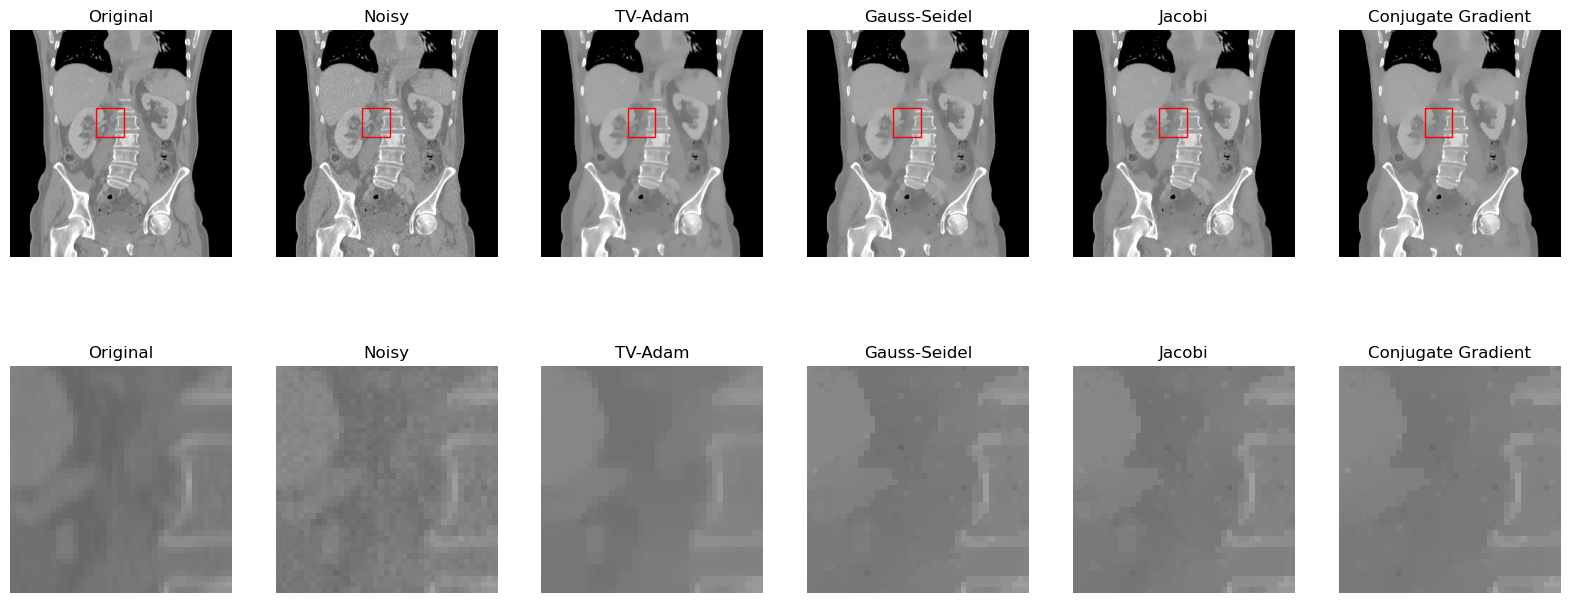

In [21]:
from utils import show_comparison_TV

show_comparison_TV(img.view(H1,W1),noise_img.view(H1,W1),x_tv.view(H1,W1),x_gs.view(H1,W1),x_jac.view(H1,W1),x_cg.view(H1,W1))



## Bonus Python: Bilateral Grid (4 XP)
With the bilateral grid the bilateral filter can be accelerated under certain conditions. This is much faster than a naive implementation if the following assumptions are made:
1. Gaussian filter is approximated by a fast rectangular filtering (dimensions separated, recursive mean value)
2. The grid is built with 16 quantisation layers.

We normalise the input image (ct_image_pytorch.pth) using `torch.clamp(img+500,0,1200)/1200`.

In [22]:
I = torch.load('ct_image_pytorch.pth').add(500).clamp(0, 1200).div(1200)


For the implementation of the bilateral grid the function `torch.nn.functional.avg_pool2d` can be used (applying it twice with `kernel_size=11, stride=1, padding=5` is sufficient as approximation of the Gaussian filter). You can use `torch.linspace(0,1,16).view(1,-1,1,1)` to obtain a vector with $a=16$ quantisation levels. All layers of the 3D bilateral grid and the corresponding weight tensor can be computed in parallel (the 16 quantisation levels are in the channel dimension). The filter weights $w(a,y)$ which depend on the considered intensity values $a$ (from your quantization levels). For the second tensor $I_A(a,y)$ the respective filter weight is multiplied by the image intensity:
$$\begin{align}
w(a,y)&=\exp\left(-\frac{(a-I(y))^2}{2\sigma^2_I}\right)\\
I_A(a,y)&=w(a,y)I(y)
\end{align}$$


These multi-channel images are smoothed (using avg_pool2d). In the last step, the output value $I’(x)$ is calculated as a quotient of the filter results $I’_A/w’$, and the correct 3D position is selected (the Slicing) for those x for which $a \approx I(x)$ applies. $w'$ denotes a smoothed version of $w$. You can use the command `torch.gather` for this purpose and obtain the required index tensor using `torch.argmax` on the weight tensor.  Test the method using $\sigma_I = 0.05$.

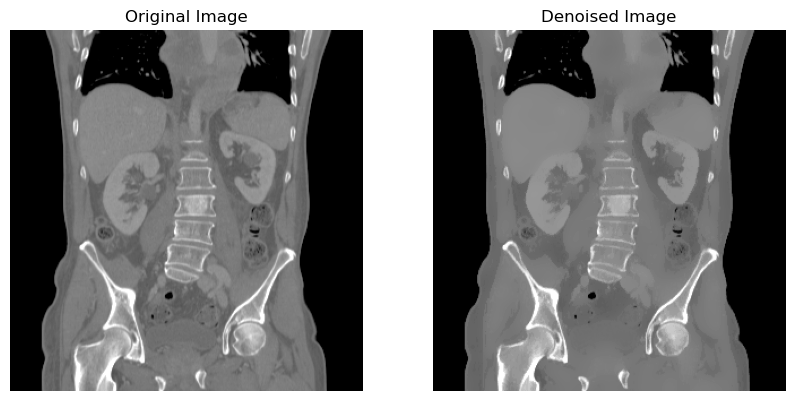

In [23]:
def smooth(x: torch.Tensor, n: int, kernel_size: int = 11, padding: int = 5, stride: int = 1):
    for _ in range(n):
        x = torch.nn.functional.avg_pool2d(x, kernel_size, stride, padding)
    return x

sigma = 0.05
a = 16

w = (torch.linspace(0, 1, a).view(1, -1, 1, 1) - I).pow(2).div(2*sigma**2).neg().exp()
I_A = w * I

w_prime = smooth(w, 2)
I_A_prime = smooth(I_A, 2)

I_prime = I_A_prime / w_prime
I_prime = torch.gather(I_prime, dim=1, index=w.argmax(1, keepdims=True))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(I.squeeze(), cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(I_prime.squeeze(), cmap='gray')
ax[1].set_title('Denoised Image')
ax[1].axis('off')

plt.show()


## Bonus Task C++: Gauss-Seidel for arbitrary matrices (6 XP)
### using C++ inline extension

As we have seen Gauss-Seidel is a powerful solver for sparse linear systems that have a regular pattern of neighbourhood edges in the underlying grid graph. To achieve this while reusing the same update formula as before with forward substitution (and without the need of the red-black scheme) we create a list of neighbour indices and its corresponding values for each pixel.

---

### Implement `split_sparse` in C++

In this exercise, you will implement the `split_sparse` function in C++. This function takes a tensor of sparse indices and a tensor of corresponding values and splits them based on the unique counts of the first row of indices.

### 1. **Extract the First and Second Rows of `W_indices`**
In the sparse matrix representation, `W_indices` contains two rows. Use the LibTorch `slice` function to extract the first and second rows of `W_indices` into `W0` and `W1`, respectively.

### 2. **Find Unique Elements and Their Counts in `W0`**
We need to find the unique elements in `W0` and their counts. This is done using the function `at::_unique2` in the C++ API, which returns a tuple. The third element of the tuple contains the counts of each unique element in `W0`.

**Explanation:**
- The function `at::_unique2` returns a tuple of three elements:
    1. Unique values in `W0`
    2. Indices that map the original `W0` to the unique values
    3. Counts of unique values
- The third element is the count of each unique element, which is stored in `counts1`.

### 3. **Convert Tensor Counts to a Standard Vector**
In C++, the next step is to convert the tensor of counts (`counts1`) to a standard C++ vector, which can be used to split the values and indices later.

**Explanation:**
- `counts1.data_ptr<int64_t>()` gives the pointer to the underlying data.
- We then create a `std::vector<int64_t>` using this pointer, spanning from the start of the data to the end (`counts1.numel()` returns the number of elements in the tensor).

### 4. **Convert the Vector into an `ArrayRef` Object**
We need an `ArrayRef<int64_t>` object to pass into the `split_with_sizes` function. This is a lightweight view of the data (from the vector `counts`) and doesn’t perform any deep copies.

**Explanation:**
- This creates an `ArrayRef` from the `counts` vector. It serves as a reference to the split sizes required for the next operation.

### 5. **Split `W_values` and `W1` Based on the Count Sizes**
Using the split sizes obtained from the unique counts, we now split `W_values` and `W1`. The function `split_with_sizes` is used to split the tensor according to the given sizes.

**Explanation:**
- `split_with_sizes` takes an `ArrayRef<int64_t>` representing the split sizes and splits the tensors accordingly.
- `W_values` is split into smaller tensors corresponding to the sizes in `split_size`. Similarly, `W1` is split into smaller tensors of indices.

In [25]:
# we need to install ninja to use C++ extension (only on colab, a run time restart is necessary)
%pip install -q ninja


Note: you may need to restart the kernel to use updated packages.


In [26]:
from torch.utils.cpp_extension import load_inline

source = """
using namespace torch::indexing;

std::tuple<std::vector<at::Tensor>, std::vector<at::Tensor>> split_sparse(torch::Tensor W_indices,torch::Tensor W_values){

    // Todo: W0 corresponds to the first row of W_indices
    torch::Tensor W0 = W_indices.index({0,Slice()});
    // Todo: W1 corresponds to the second row of W_indices
    torch::Tensor W1 = W_indices.index({1,Slice()});
    
    // Todo: counts1 contains the number of occurences of each unique value in W0
    // use the function at::_unique2 to get the unique values and their counts: https://pytorch.org/cppdocs/api/function_namespaceat_1a28145bef068552503315f365afa3e676.html
    // This function returns a tuple, to get counts you have to access the correct element of the tuple with std::get<n>(at::_unique2(...))
    torch::Tensor counts1 = std::get<2>(at::_unique2(W0,true,false,true));
    
    // Todo: Convert counts1 to a list of sizes to be used in splitting
    // for this you can use the constructor of std::vector<int64_t> with the data_ptr of counts1 and counts1.numel()
    // then convert the vector to a c10::ArrayRef<int64_t> with the constructor of c10::ArrayRef<int64_t>
    std::vector<int64_t> counts(counts1.data_ptr<int64_t>(), counts1.data_ptr<int64_t>() + counts1.numel());
    c10::ArrayRef<int64_t> split_size(counts);
    
    // Todo: split W_values and W1 using the sizes in split_size
    auto value_list = W_values.split_with_sizes(split_size);
    auto index_list = W1.split_with_sizes(split_size);
    
    return std::make_tuple(value_list,index_list);
    }
"""
mod_split = load_inline(name='inline_extension',cpp_sources=[source],functions=['split_sparse'], verbose=True )
print('first compile done')



Using /Users/chris/Library/Caches/torch_extensions/py311_cpu as PyTorch extensions root...
Emitting ninja build file /Users/chris/Library/Caches/torch_extensions/py311_cpu/inline_extension/build.ninja...
Building extension module inline_extension...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/2] c++ -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=inline_extension -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_clang\" -DPYBIND11_STDLIB=\"_libcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1002\" -isystem /Users/chris/miniforge3/envs/autosafe/lib/python3.11/site-packages/torch/include -isystem /Users/chris/miniforge3/envs/autosafe/lib/python3.11/site-packages/torch/include/torch/csrc/api/include -isystem /Users/chris/miniforge3/envs/autosafe/lib/python3.11/site-packages/torch/include/TH -isystem /Users/chris/miniforge3/envs/autosafe/lib/python3.11/site-packages/torch/include/THC -isystem /Users/chris/miniforge3/envs/autosafe/include/python3.11 -D_GLIBCXX_USE_CXX11_ABI=0 -fPIC -std=c++17 -c /Users/chris/Library/Caches/torch_extensions/py311_cpu/inline_extension/main.cpp -o main.o 
[2/2] c++ main.o -shared -L/Users/chris/miniforge3/envs/autosafe/lib/python3.11/site-packages/torch/lib -lc10 -ltorch_cpu -ltorch -ltorch_python -undefined dynamic_lookup -o inline_extension.so
first co

Loading extension module inline_extension...


### Implement the `iterative_solve` function in C++

Here, you will need to setup the `iterative_solve` function in C++ for arbitrary matrices. This function takes a tensor of sparse indices, a tensor of corresponding values, a tensor of the main diagonal elements, and the number of iterations. 

You will need to implement the Gauss-Seidel method to solve the linear system of equations (as defined in Task 1) for the given number of iterations.


In [27]:
from torch.utils.cpp_extension import load_inline

source = """
using namespace torch::indexing;
using namespace at;

std::tuple<Tensor, Tensor> iterative_solve(Tensor diag_vec, std::vector<Tensor> value_list, 
                                           std::vector<Tensor> index_list, Tensor b, int iterations) {

    Tensor x1 = b.clone();  // Remove detach, it's redundant if not needed
    Tensor x_all = torch::zeros({iterations, x1.numel()});
    
    // Given: We will use accessors(https://pytorch.org/cppdocs/notes/tensor_basics.html) here for speed
    // We set the datatype and dimensionality of the accessor, here we have 1D tensors
    // Throughout the loop we will then use the accessor to access the data of the tensors
    auto diag_vec_accessor = diag_vec.accessor<float, 1>();
    auto x1_accessor = x1.accessor<float, 1>();
    auto b_accessor = b.accessor<float, 1>();

    for (int i = 0; i < iterations; ++i) {
        // Given: for paralell execution we use at::parallel_for(start, end, grain_size, ....)
        at::parallel_for(0, index_list.size(), 0, [&](int64_t start, int64_t end) {
            for (int j = start; j < end; ++j) {
                // Todo: index the unfolded x1 tensor with the indices from index_list (neighbor indices)
                Tensor x1_indexed = x1.index({index_list[j]});
                // Todo: multiply the neighbors with the corresponding weights
                Tensor value_mul_x1 = value_list[j] * x1_indexed;
                // Todo: sum the values
                float sum_value_mul_x1 = value_mul_x1.sum().item<float>();

                // Todo: update x1 using the simplified Gauss-Seidel formula
                x1_accessor[j] = (1./diag_vec_accessor[j])*(b_accessor[j] - sum_value_mul_x1);
            }
        });
        x_all.index_put_({i}, x1);
    }
    
    return std::make_tuple(x1, x_all);
}
"""
gauss_seidel = load_inline(name='inline_extension',cpp_sources=[source],\
                            extra_cflags=["-g\n\n", "-O3 -Wall"],
                            verbose=True, 
                           functions=['iterative_solve'])#,extra_cflags="-O3")
print('second compile done')


Using /Users/chris/Library/Caches/torch_extensions/py311_cpu as PyTorch extensions root...
The input conditions for extension module inline_extension have changed. Bumping to version 1 and re-building as inline_extension_v1...
Emitting ninja build file /Users/chris/Library/Caches/torch_extensions/py311_cpu/inline_extension/build.ninja...
Building extension module inline_extension_v1...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/2] c++ -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=inline_extension_v1 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_clang\" -DPYBIND11_STDLIB=\"_libcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1002\" -isystem /Users/chris/miniforge3/envs/autosafe/lib/python3.11/site-packages/torch/include -isystem /Users/chris/miniforge3/envs/autosafe/lib/python3.11/site-packages/torch/include/torch/csrc/api/include -isystem /Users/chris/miniforge3/envs/autosafe/lib/python3.11/site-packages/torch/include/TH -isystem /Users/chris/miniforge3/envs/autosafe/lib/python3.11/site-packages/torch/include/THC -isystem /Users/chris/miniforge3/envs/autosafe/include/python3.11 -D_GLIBCXX_USE_CXX11_ABI=0 -fPIC -std=c++17 -g -O3 -Wall -c /Users/chris/Library/Caches/torch_extensions/py311_cpu/inline_extension/main.cpp -o main.o 
[2/2] c++ main.o -shared -L/Users/chris/miniforge3/envs/autosafe/lib/python3.11/site-packages/torch/lib -lc10 -ltorch_cpu -ltorch -ltorch_python -undefined dynamic_lookup -o inline_exten

Loading extension module inline_extension_v1...


Let's use the C++ inline extensions, first we will need to split the sparse matrix. 

In [29]:
_, index_unfold = laplacian(noise_img, weights, neighbours, diag)
W_sparse = torch.sparse_coo_tensor(torch.stack((torch.arange(H1*W1).view(1,-1).repeat(4,1),index_unfold),0).view(2,-1),weights.view(-1),size=(H1*W1,H1*W1))
W_sparse = W_sparse.coalesce()

# Todo: call the split_sparse function from the compiled module
value_list,index_list = mod_split.split_sparse(W_sparse.indices(),W_sparse.values())


Now we can use the Gauss-Seidel method to solve the linear system of equations for the given number of iterations.

In [31]:
# this is surprisingly slow
t0 = time.time()
x_cg_cpp,x_cg_cpp_all = gauss_seidel.iterative_solve(diag.view(-1),value_list,index_list,img.reshape(-1),50)
t1 = time.time()

time_gs_cpp = t1-t0
print(f'Gauss-Seidel C++ took {time_gs_cpp:.2f} seconds')

residual = (noise_img.reshape(-1)-torch.spmm(L,x_cg_cpp.view(-1,1)).squeeze())

print(f'Gauss-Seidel C++ residual: {residual.norm()}')



Gauss-Seidel C++ took 4.20 seconds
Gauss-Seidel C++ residual: 10816.4208984375


Let's have a look at the C++ output of the code below.

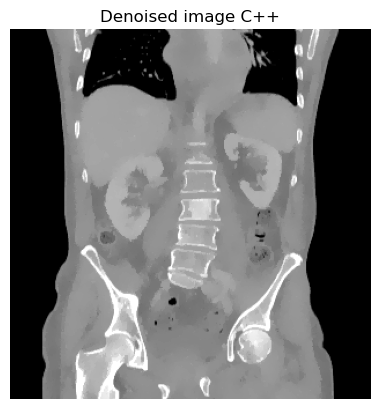

In [33]:
plt.imshow(x_cg_cpp.view(H1,W1).clamp(-500,500),cmap='gray')
plt.title('Denoised image C++')
plt.axis('off')
plt.show()


To compare to the different methods we need to compute the residuals of the C++ implementation.

In [34]:
gs_residualscpp = torch.zeros(x_cg_cpp_all.size(0))
for i in range(x_cg_cpp_all.size(0)):
    residual = (noise_img.reshape(-1)-torch.spmm(L,x_cg_cpp_all[i].view(-1,1)).squeeze())
    gs_residualscpp[i] = residual.norm()


Now Let's compare the results of the Gauss-Seidel solver with the given Python implementation.

Text(0, 0.5, 'Residual')

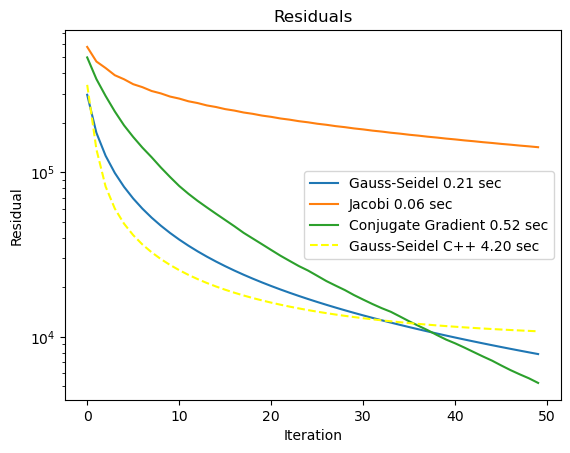

In [35]:
times = [time_gs,time_jac,time_cg, time_gs_cpp]

plt.plot(gs_residual,label=f'Gauss-Seidel {times[0]:.2f} sec')
plt.plot(jac_residual,label=f'Jacobi {times[1]:.2f} sec')
plt.plot(cg_residuals,label=f'Conjugate Gradient {times[2]:.2f} sec')
plt.plot(gs_residualscpp,label=f'Gauss-Seidel C++ {times[3]:.2f} sec', linestyle='--', color='yellow')
plt.yscale('log')
plt.legend()

# put times in the plot labels
plt.title('Residuals')
plt.xlabel('Iteration')
plt.ylabel('Residual')

